In [0]:
!pwd

/content


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Description of the data
1. newacct no: Unique customer id
2. line_stat, bill_cycl, serv_type, serv_code - Ignorable columns (Use them in case you find a co-relation, but mostly they can be ignored)
3. tenure - (customer is in the system since how many months
4. effc strt date, end date --> Contract start date and end date
5. contract_month - Contract type
6. ce_expiry - sysdate - contract expiry date, if expiry date is jan'19, and today is jan'2020, then ce_expiry is -12, if expiry date is jan'21, and today is jan'2020, then ce_expiry is 12.
7. secured_revenue - monthly revenue
8. bandwidth
9. term reason code, desc - ignore
10. complaint_cnt - number of complaint calls done by customer every month
11. with_phone_service - whether broadband customer has taken a phone service seaprately or not.
12. churn - churned or not
13. current_mth_churn - the month where the customer is churned, let say customer got churned in june'19, and we have data from jan'19 to jan'20, then all the records of column churn for this customer willl be Y, but only june'19 record will have current_mth_churn as Y


# Importing the libraries

In [0]:
!pip install bayesian-optimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from collections import Counter
from sklearn.metrics import f1_score,classification_report,confusion_matrix

In [0]:
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)

In [0]:
rdf = pd.read_csv('/content/drive/My Drive/Churn_prediction/bbs_cust_base_scfy_20200210.csv', error_bad_lines=False)

b'Skipping line 85316: expected 19 fields, saw 20\n'
b'Skipping line 249148: expected 19 fields, saw 20\n'
b'Skipping line 318801: expected 19 fields, saw 20\n'


In [0]:
rdf.shape

(510122, 19)

In [0]:
rdf.tail()

,image,newacct_no,line_stat,bill_cycl,serv_type,serv_code,tenure,effc_strt_date,effc_end_date,contract_month,ce_expiry,secured_revenue,bandwidth,term_reas_code,term_reas_desc,complaint_cnt,with_phone_service,churn,current_mth_churn
510117,201912,96556659.001.000097362,AC,1,BBS,PF1000DUN,0,31.12.2019 00:00:00,30.12.2021 00:00:00,24.0,23.0,0.0,1000M (FTTO),NaN,NaN,0,N,N,N
510118,201912,96561147.001.000097409,AC,1,BBS,VS100DUN,0,31.12.2019 00:00:00,30.12.2021 00:00:00,24.0,23.0,0.0,100M,NaN,NaN,0,N,N,N
510119,201912,96562046.001.000068616,AC,1,BBS,VPXMXMDURN,70,12.03.2019 00:00:00,11.03.2021 00:00:00,24.0,13.0,0.0,10M,NaN,NaN,0,N,N,N
510120,201912,96562046.001.000082585,AC,1,BBS,VS100DUSAR,34,04.03.2019 00:00:00,03.03.2021 00:00:00,24.0,13.0,0.0,100M,NaN,NaN,0,N,N,N
510121,201912,96569066.001.000095968,AC,1,BBS,PF1000DUN,3,19.09.2019 00:00:00,18.09.2021 00:00:00,24.0,19.0,0.0,1000M (FTTO),NaN,NaN,0,N,N,N


In [0]:
#testset
df_train = rdf[~rdf['image'].isin([201910,201911,201912])]
df_test = rdf[rdf['image'].isin([201910,201911,201912])]

Converting the date columns to datetime

In [0]:
print(df_train.shape)
print(df_test.shape)

(443830, 19)
(66292, 19)


In [0]:
def date_type(df, col):
  df[col] = pd.to_datetime(df[col], dayfirst=True)
  return df[col]

df_train['effc_strt_date'] = date_type(df_train,'effc_strt_date')
df_train['effc_end_date'] = date_type(df_train, 'effc_end_date')

#test set
df_test['effc_strt_date'] = date_type(df_test,'effc_strt_date')
df_test['effc_end_date'] = date_type(df_test, 'effc_end_date')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [0]:
df_train.head()

,image,newacct_no,line_stat,bill_cycl,serv_type,serv_code,tenure,effc_strt_date,effc_end_date,contract_month,ce_expiry,secured_revenue,bandwidth,term_reas_code,term_reas_desc,complaint_cnt,with_phone_service,churn,current_mth_churn
0,201801,70068143.001.000000062,AC,1,BBS,VS100DUN,202,2018-03-06,2021-03-05,36.0,13.0,178.0,100M,NaN,NaN,0,N,N,N
1,201801,70068143.003.000072630,AC,1,BBS,VS030F6R,35,2019-03-01,2021-02-28,24.0,13.0,1572.0,30M,NaN,NaN,0,N,N,N
2,201801,70071840.001.000000066,AC,1,BBS,EAXMXMFSRN1,202,2019-10-01,2021-09-30,24.0,20.0,290.0,10M,NaN,NaN,0,Y,N,N
3,201801,70071840.003.000060034,AC,1,BBS,VS100DUN,72,2018-11-07,2020-11-06,24.0,9.0,218.0,100M,NaN,NaN,0,Y,N,N
4,201801,70076500.001.000000073,AC,1,BBS,PF100FSR,202,2017-05-01,2019-04-30,24.0,-9.0,430.0,100M (FTTO),NaN,NaN,0,N,Y,N


In [0]:
print(f'Number of unique values')
for i in df_train.columns:
  print(f'{i}:', df_train[i].nunique())

Number of unique values
image: 21
newacct_no: 26714
line_stat: 3
bill_cycl: 1
serv_type: 1
serv_code: 238
tenure: 223
effc_strt_date: 2085
effc_end_date: 2318
contract_month: 56
ce_expiry: 178
secured_revenue: 9192
bandwidth: 9
term_reas_code: 24
term_reas_desc: 24
complaint_cnt: 8
with_phone_service: 2
churn: 2
current_mth_churn: 2


From the above values we can ignore the bill cycle, serv_type and line_stat since it is constant

In [0]:
missing = pd.DataFrame(df_train.isna().sum(), columns=['Percentage'])
missing['Percentage'] = missing['Percentage']/len(df_train)*100

In [0]:
missing

,Percentage
image,0.000000
newacct_no,0.000000
line_stat,0.000000
bill_cycl,0.000000
serv_type,0.000000
serv_code,0.000000
tenure,0.000000
effc_strt_date,0.403082
effc_end_date,0.403082
contract_month,0.403082


Most of the records in term_reas_code and term_reas_desc is missing

When the customer is not using the service means Churn value will be Y and current_churn_month will be yes only in the corresponding month 

In [0]:
df1 = df_train.groupby(['newacct_no','serv_code','bandwidth','with_phone_service','current_mth_churn']).agg({
    'tenure':'max',
    'effc_strt_date':'min',
    'effc_end_date':'max',
    'secured_revenue':'max',
    'complaint_cnt':'sum'
}).reset_index()

df_test1 = df_test.groupby(['newacct_no','serv_code','bandwidth','with_phone_service','current_mth_churn']).agg({
    'tenure':'max',
    'effc_strt_date':'min',
    'effc_end_date':'max',
    'secured_revenue':'max',
    'complaint_cnt':'sum'
}).reset_index()

In [0]:
df1['current_mth_churn'].value_counts()

N    39200
Y     4696
Name: current_mth_churn, dtype: int64

In [0]:
df_test1['current_mth_churn'].value_counts()

N    23860
Y      803
Name: current_mth_churn, dtype: int64

It is a highly imbalanced dataset

In [0]:
df1['contract_tenure'] = (df1['effc_end_date'] - df1['effc_strt_date']).dt.days
df_test1['contract_tenure'] = (df_test1['effc_end_date'] - df_test1['effc_strt_date']).dt.days

In [0]:
df1['contract_tenure'].describe()

count    43677.000000
mean       748.350757
std        161.368113
min          5.000000
25%        730.000000
50%        730.000000
75%        730.000000
max       3652.000000
Name: contract_tenure, dtype: float64

In [0]:
df1.head()

,newacct_no,serv_code,bandwidth,with_phone_service,current_mth_churn,tenure,effc_strt_date,effc_end_date,secured_revenue,complaint_cnt,contract_tenure
0,70068143.001.000000062,PF500DUN,500M (FTTO),N,N,222,2018-03-06,2021-03-05,248.0,0,1095.0
1,70068143.001.000000062,VS100DUN,100M,N,N,206,2018-03-06,2021-03-05,178.0,0,1095.0
2,70068143.003.000072630,VS030F6N,30M,N,N,55,2019-03-01,2021-02-28,5799.0,0,730.0
3,70068143.003.000072630,VS030F6R,30M,N,N,48,2019-03-01,2021-02-28,1572.0,0,730.0
4,70068143.004.000089578,PF1000FSH,1000M (FTTO),N,N,15,2018-07-09,2020-07-08,488.0,0,730.0


# EDA

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'churned')

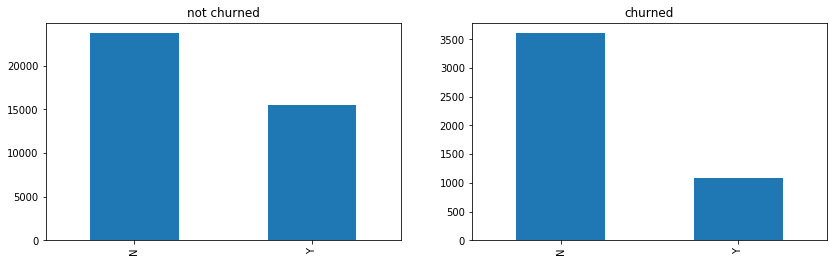

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df1[df1['current_mth_churn'] == 'N']['with_phone_service'].value_counts().plot('bar',ax=ax[0]).set_title('not churned')
df1[df1['current_mth_churn'] == 'Y']['with_phone_service'].value_counts().plot('bar',ax=ax[1]).set_title('churned')

Most of the people dont have the Phone connection who got churned

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'churned')

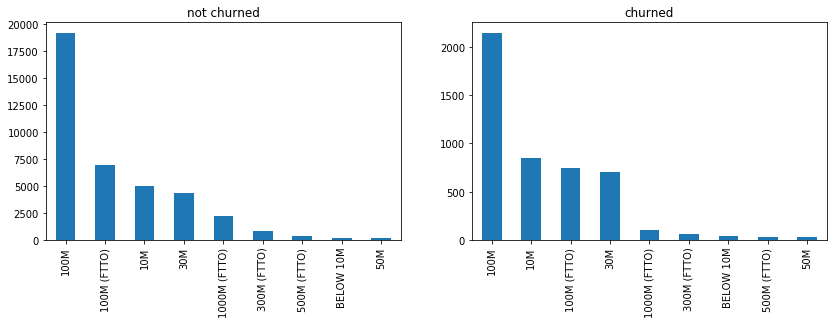

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df1[df1['current_mth_churn'] == 'N']['bandwidth'].value_counts().plot('bar',ax=ax[0]).set_title('not churned')
df1[df1['current_mth_churn'] == 'Y']['bandwidth'].value_counts().plot('bar',ax=ax[1]).set_title('churned')

People who have churned most likely have the bandwidht of 100M

In [0]:
df1['secured_revenue'].describe()

count    43896.000000
mean       919.135455
std       2199.557640
min       -385.220000
25%        184.000000
50%        345.740000
75%        828.445000
max      61161.290000
Name: secured_revenue, dtype: float64

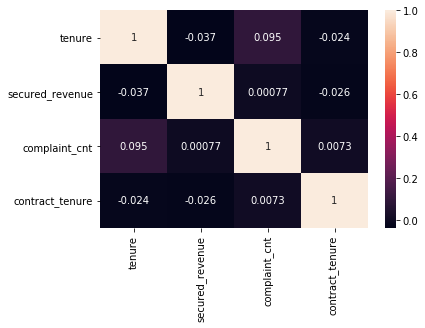

In [0]:
sns.heatmap(df1.corr(), annot=True)

Bin values obtained based on the percentile values

In [0]:
pd.cut(df1['secured_revenue'],bins=[-400,0,200,400,900,62000]).value_counts()

(0, 200]        13358
(400, 900]      10758
(200, 400]      10217
(900, 62000]     9115
(-400, 0]         448
Name: secured_revenue, dtype: int64

In [0]:
df1['secured_revenue_bins'] = pd.cut(df1['secured_revenue'],bins=[-400,0,200,400,900,62000], labels=False)
df_test1['secured_revenue_bins'] = pd.cut(df_test1['secured_revenue'],bins=[-400,0,200,400,900,62000], labels=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'churned')

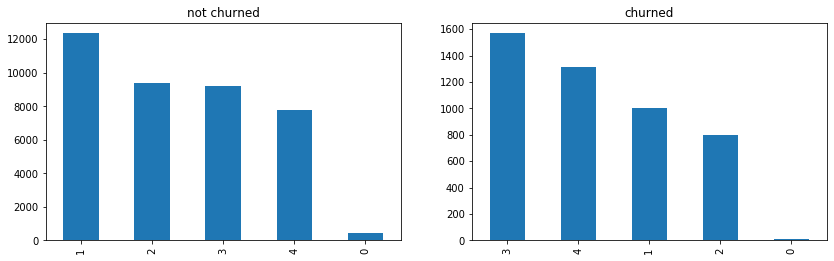

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df1[df1['current_mth_churn'] == 'N']['secured_revenue_bins'].value_counts().plot('bar',ax=ax[0]).set_title('not churned')
df1[df1['current_mth_churn'] == 'Y']['secured_revenue_bins'].value_counts().plot('bar',ax=ax[1]).set_title('churned')

From the chart we can see most of the people churned generated revenue between 400 to 900

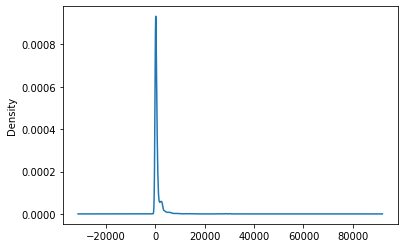

In [0]:

df1['secured_revenue'].plot(kind = 'kde')

In [0]:
df1['tenure'].describe()

count    43896.000000
mean        64.613974
std         51.002795
min          0.000000
25%         24.000000
50%         48.000000
75%         97.000000
max        222.000000
Name: tenure, dtype: float64

In [0]:
pd.cut(df1['tenure'],bins=[0,24,48,72,250]).value_counts()

(72, 250]    15693
(0, 24]      13237
(24, 48]      9213
(48, 72]      5609
Name: tenure, dtype: int64

In [0]:
df1['tenure_bins'] = pd.cut(df1['tenure'],bins=[0,24,48,72,250], labels=False)
df_test1['tenure_bins'] = pd.cut(df_test1['tenure'],bins=[0,24,48,72,250], labels=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'churned')

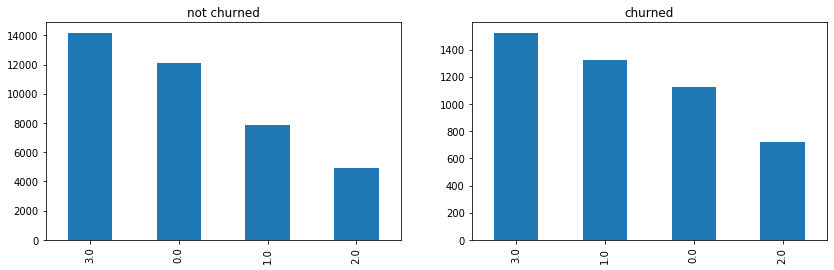

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df1[df1['current_mth_churn'] == 'N']['tenure_bins'].value_counts().plot('bar',ax=ax[0]).set_title('not churned')
df1[df1['current_mth_churn'] == 'Y']['tenure_bins'].value_counts().plot('bar',ax=ax[1]).set_title('churned')

# Feature Engineering

In [0]:
df1 = df1.dropna()

In [0]:
df1['contract_tenure_months'] = df1['contract_tenure']/12

df_test1['contract_tenure_months'] = df_test1['contract_tenure']/12

In [0]:
def features(df1):
  df1['ratio_retention_contract'] = df1['tenure']/df1['contract_tenure_months']
  df1['ration_tenure_complaint'] = df1['complaint_cnt']/df1['contract_tenure']
  df1['ratio_tenure_revenue'] = df1['secured_revenue']/df1['tenure']
  df1['ratio_contract_tenure_revenue'] = df1['secured_revenue']/df1['contract_tenure']
  return df1

df1 = features(df1)
df_test1 = features(df_test1)

In [0]:
df1.head()

,newacct_no,serv_code,bandwidth,with_phone_service,current_mth_churn,tenure,effc_strt_date,effc_end_date,secured_revenue,complaint_cnt,contract_tenure,secured_revenue_bins,tenure_bins,contract_tenure_months,ratio_retention_contract,ration_tenure_complaint,ratio_tenure_revenue,ratio_contract_tenure_revenue
0,70068143.001.000000062,PF500DUN,500M (FTTO),N,N,222,2018-03-06,2021-03-05,248.0,0,1095.0,2,3.0,91.250000,2.432877,0.0,1.117117,0.226484
1,70068143.001.000000062,VS100DUN,100M,N,N,206,2018-03-06,2021-03-05,178.0,0,1095.0,1,3.0,91.250000,2.257534,0.0,0.864078,0.162557
2,70068143.003.000072630,VS030F6N,30M,N,N,55,2019-03-01,2021-02-28,5799.0,0,730.0,4,2.0,60.833333,0.904110,0.0,105.436364,7.943836
3,70068143.003.000072630,VS030F6R,30M,N,N,48,2019-03-01,2021-02-28,1572.0,0,730.0,4,1.0,60.833333,0.789041,0.0,32.750000,2.153425
4,70068143.004.000089578,PF1000FSH,1000M (FTTO),N,N,15,2018-07-09,2020-07-08,488.0,0,730.0,3,0.0,60.833333,0.246575,0.0,32.533333,0.668493


In [0]:
# datetime based features
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)
    return df

In [0]:
df1 = add_datepart(df1, 'effc_strt_date',drop=False)
df_test1 = add_datepart(df_test1, 'effc_strt_date',drop=False)

In [0]:
df1 = add_datepart(df1, 'effc_end_date',drop=False)
df_test1 = add_datepart(df_test1, 'effc_end_date',drop=False)

In [0]:
df1.head()

,newacct_no,serv_code,bandwidth,with_phone_service,current_mth_churn,tenure,effc_strt_date,effc_end_date,secured_revenue,complaint_cnt,contract_tenure,secured_revenue_bins,tenure_bins,contract_tenure_months,ratio_retention_contract,ration_tenure_complaint,ratio_tenure_revenue,ratio_contract_tenure_revenue,effc_strt_Year,effc_strt_Month,effc_strt_Week,effc_strt_Day,effc_strt_Dayofweek,effc_strt_Dayofyear,effc_strt_Is_month_end,effc_strt_Is_month_start,effc_strt_Is_quarter_end,effc_strt_Is_quarter_start,effc_strt_Is_year_end,effc_strt_Is_year_start,effc_strt_Elapsed,effc_end_Year,effc_end_Month,effc_end_Week,effc_end_Day,effc_end_Dayofweek,effc_end_Dayofyear,effc_end_Is_month_end,effc_end_Is_month_start,effc_end_Is_quarter_end,effc_end_Is_quarter_start,effc_end_Is_year_end,effc_end_Is_year_start,effc_end_Elapsed
0,70068143.001.000000062,PF500DUN,500M (FTTO),N,N,222,2018-03-06,2021-03-05,248.0,0,1095.0,2,3.0,91.250000,2.432877,0.0,1.117117,0.226484,2018,3,10,6,1,65,False,False,False,False,False,False,1520294400,2021,3,9,5,4,64,False,False,False,False,False,False,1614902400
1,70068143.001.000000062,VS100DUN,100M,N,N,206,2018-03-06,2021-03-05,178.0,0,1095.0,1,3.0,91.250000,2.257534,0.0,0.864078,0.162557,2018,3,10,6,1,65,False,False,False,False,False,False,1520294400,2021,3,9,5,4,64,False,False,False,False,False,False,1614902400
2,70068143.003.000072630,VS030F6N,30M,N,N,55,2019-03-01,2021-02-28,5799.0,0,730.0,4,2.0,60.833333,0.904110,0.0,105.436364,7.943836,2019,3,9,1,4,60,False,True,False,False,False,False,1551398400,2021,2,8,28,6,59,True,False,False,False,False,False,1614470400
3,70068143.003.000072630,VS030F6R,30M,N,N,48,2019-03-01,2021-02-28,1572.0,0,730.0,4,1.0,60.833333,0.789041,0.0,32.750000,2.153425,2019,3,9,1,4,60,False,True,False,False,False,False,1551398400,2021,2,8,28,6,59,True,False,False,False,False,False,1614470400
4,70068143.004.000089578,PF1000FSH,1000M (FTTO),N,N,15,2018-07-09,2020-07-08,488.0,0,730.0,3,0.0,60.833333,0.246575,0.0,32.533333,0.668493,2018,7,28,9,0,190,False,False,False,False,False,False,1531094400,2020,7,28,8,2,190,False,False,False,False,False,False,1594166400


# Encoding and standardising the data

In [0]:
from datetime import datetime
def features2(df1):
  df1['diff_week'] = df1['effc_end_Week'] - df1['effc_strt_Week']
  df1['diff_day'] = df1['effc_end_Day'] - df1['effc_strt_Day']
  df1['tenure_pending_days'] = (df1['effc_end_date'] - pd.to_datetime(datetime.now().date())).dt.days
  df1['tenure_past_days'] = (pd.to_datetime(datetime.now().date()) - df1['effc_strt_date']).dt.days
  df1['ratio_past_pending'] = df1['tenure_pending_days']/df1['tenure_past_days']
  return df1

df1 = features2(df1)
df_test1 = features2(df_test1)

In [0]:
def category(df1):
  df1['serv_code'] = df1['serv_code'].astype('category')
  df1['bandwidth'] = df1['bandwidth'].astype('category')
  df1['with_phone_service'] = df1['with_phone_service'].astype('category')
  df1['tenure_bins'] = df1['tenure_bins'].astype('category')
  df1['secured_revenue_bins'] = df1['secured_revenue_bins'].astype('category')
  return df1
df1 = category(df1)
df_test1 = category(df_test1)

In [0]:
bool_dt = ['effc_end_Is_month_end','effc_end_Is_month_start','effc_end_Is_quarter_end',\
           'effc_end_Is_quarter_start','effc_end_Is_year_end','effc_end_Is_year_start',\
           'effc_strt_Is_month_end','effc_strt_Is_month_start','effc_strt_Is_quarter_end',\
           'effc_strt_Is_quarter_start','effc_strt_Is_year_end','effc_strt_Is_year_start']
for i in bool_dt:
  df1[i] = df1[i].astype('int')
  df_test1[i] = df_test1[i].astype('int')
  

In [0]:
df1.describe()

,tenure,secured_revenue,complaint_cnt,contract_tenure,contract_tenure_months,ratio_retention_contract,ration_tenure_complaint,ratio_tenure_revenue,ratio_contract_tenure_revenue,effc_strt_Year,effc_strt_Month,effc_strt_Week,effc_strt_Day,effc_strt_Dayofweek,effc_strt_Dayofyear,effc_strt_Is_month_end,effc_strt_Is_month_start,effc_strt_Is_quarter_end,effc_strt_Is_quarter_start,effc_strt_Is_year_end,effc_strt_Is_year_start,effc_strt_Elapsed,effc_end_Year,effc_end_Month,effc_end_Week,effc_end_Day,effc_end_Dayofweek,effc_end_Dayofyear,effc_end_Is_month_end,effc_end_Is_month_start,effc_end_Is_quarter_end,effc_end_Is_quarter_start,effc_end_Is_year_end,effc_end_Is_year_start,effc_end_Elapsed,diff_week,diff_day,tenure_pending_days,tenure_past_days,ratio_past_pending
count,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,4.355200e+04,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000,4.355200e+04,43552.000000,43552.000000,43552.000000,43552.000000,43552.000000
mean,64.992974,918.424090,0.308666,748.411485,62.367624,1.098600,0.000428,45.014184,1.499329,2017.946202,6.454353,26.044567,13.937707,2.856126,179.066495,0.037289,0.173356,0.011021,0.046841,0.001630,0.008702,1.528441e+09,2019.987509,6.397869,26.421611,18.214525,3.181025,181.886159,0.173540,0.027025,0.047116,0.007715,0.008450,0.001998,1.593104e+09,0.377044,4.276819,128.701621,619.709864,1.403527
std,50.962500,2195.577692,2.068513,161.317883,13.443157,1.121304,0.002978,410.035525,11.505516,1.282768,3.269392,14.251010,9.841025,1.886364,99.932570,0.189471,0.378559,0.104403,0.211300,0.040344,0.092880,4.015088e+07,1.319617,3.272728,14.344377,9.666697,1.998029,99.952946,0.378718,0.162159,0.211890,0.087496,0.091534,0.044651,4.139164e+07,8.301755,11.543524,479.069959,464.709225,4.096712
min,1.000000,-385.220000,0.000000,5.000000,0.416667,0.003286,0.000000,-2.049043,-0.702956,2004.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.093997e+09,2005.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.120090e+09,-52.000000,-29.000000,-5346.000000,11.000000,-0.981343
25%,24.000000,186.000000,0.000000,730.000000,60.833333,0.394521,0.000000,3.679511,0.244170,2018.000000,4.000000,14.000000,4.000000,1.000000,94.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.517443e+09,2020.000000,4.000000,14.000000,10.000000,1.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.581034e+09,-1.000000,-1.000000,-11.000000,296.000000,-0.013532
50%,48.000000,348.000000,0.000000,730.000000,60.833333,0.789041,0.000000,8.235294,0.479452,2018.000000,6.000000,26.000000,14.000000,3.000000,179.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.537920e+09,2020.000000,6.000000,26.000000,19.000000,3.000000,181.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.601338e+09,0.000000,-1.000000,224.000000,510.000000,0.439842
75%,97.000000,830.547500,0.000000,730.000000,60.833333,1.594521,0.000000,22.910615,1.164474,2019.000000,9.000000,37.000000,23.000000,4.000000,259.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.556410e+09,2021.000000,9.000000,38.000000,28.000000,5.000000,262.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.620173e+09,0.000000,-1.000000,442.000000,747.000000,1.482993
max,222.000000,61161.290000,62.000000,3652.000000,304.333333,67.200000,0.115068,28524.000000,1232.220000,2020.000000,12.000000,53.000000,31.000000,6.000000,366.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.581034e+09,2029.000000,12.000000,53.000000,31.000000,6.000000,366.000000,1.000000,1.000000,1.000000,1.000000,1.

In [0]:
features_to_scale = ['secured_revenue','contract_tenure','ratio_tenure_revenue',\
                     'ratio_contract_tenure_revenue','effc_end_Elapsed',\
                     'effc_strt_Elapsed']
  


In [0]:
df_test1[features_to_scale].describe()

,secured_revenue,contract_tenure,ratio_tenure_revenue,ratio_contract_tenure_revenue,effc_end_Elapsed,effc_strt_Elapsed
count,24663.000000,24609.000000,2.456400e+04,24609.000000,2.466300e+04,2.466300e+04
mean,702.435269,761.374619,inf,0.987238,1.586997e+09,1.521358e+09
std,2101.298706,176.767502,NaN,5.700990,5.073147e+08,5.041574e+08
min,-385.220000,5.000000,-2.016859e+00,-0.702956,-9.223372e+09,-9.223372e+09
25%,158.000000,730.000000,2.426410e+00,0.205479,1.594685e+09,1.530230e+09
50%,225.000000,730.000000,6.086957e+00,0.301370,1.612051e+09,1.548202e+09
75%,464.000000,730.000000,1.880000e+01,0.641096,1.630195e+09,1.565568e+09
max,45631.000000,3652.000000,inf,760.000000,1.883606e+09,1.581034e+09


In [0]:
# in test set for one of the features we have inf as value in one column replacing inf with zero in that columns
df_test1[features_to_scale] = df_test1[features_to_scale].replace({np.inf:0})

In [0]:
min_max = MinMaxScaler()
df1[features_to_scale] = min_max.fit_transform(df1[features_to_scale].values)
df_test1[features_to_scale] = min_max.transform(df_test1[features_to_scale].values)

In [0]:
df1.select_dtypes(include='category')

,serv_code,bandwidth,with_phone_service,secured_revenue_bins,tenure_bins
0,PF500DUN,500M (FTTO),N,2,3.0
1,VS100DUN,100M,N,1,3.0
2,VS030F6N,30M,N,4,2.0
3,VS030F6R,30M,N,4,1.0
4,PF1000FSH,1000M (FTTO),N,3,0.0
...,...,...,...,...,...
43863,ES100DUN,100M,N,0,0.0
43870,VS100DUN,100M,N,0,0.0
43871,VS100DUN,100M,N,0,0.0
43872,PF1000DUH,1000M (FTTO),N,0,0.0


In [0]:
df1['current_mth_churn'] = df1['current_mth_churn'].replace({'N':0,'Y':1})
df_test1['current_mth_churn'] = df_test1['current_mth_churn'].replace({'N':0,'Y':1})

#**Creating only one record since there were 3/4 bandwidths per user**

In [0]:
df1.head()

,newacct_no,serv_code,bandwidth,with_phone_service,current_mth_churn,tenure,effc_strt_date,effc_end_date,secured_revenue,complaint_cnt,contract_tenure,secured_revenue_bins,tenure_bins,contract_tenure_months,ratio_retention_contract,ration_tenure_complaint,ratio_tenure_revenue,ratio_contract_tenure_revenue,effc_strt_Year,effc_strt_Month,effc_strt_Week,effc_strt_Day,effc_strt_Dayofweek,effc_strt_Dayofyear,effc_strt_Is_month_end,effc_strt_Is_month_start,effc_strt_Is_quarter_end,effc_strt_Is_quarter_start,effc_strt_Is_year_end,effc_strt_Is_year_start,effc_strt_Elapsed,effc_end_Year,effc_end_Month,effc_end_Week,effc_end_Day,effc_end_Dayofweek,effc_end_Dayofyear,effc_end_Is_month_end,effc_end_Is_month_start,effc_end_Is_quarter_end,effc_end_Is_quarter_start,effc_end_Is_year_end,effc_end_Is_year_start,effc_end_Elapsed,diff_week,diff_day,tenure_pending_days,tenure_past_days,ratio_past_pending
0,70068143.001.000000062,PF500DUN,500M (FTTO),N,0,222,2018-03-06,2021-03-05,0.010288,0,0.298876,2,3.0,91.250000,2.432877,0.0,0.000111,0.000754,2018,3,10,6,1,65,0,0,0,0,0,0,0.875288,2021,3,9,5,4,64,0,0,0,0,0,0,0.648071,-1,-1,381,714,0.533613
1,70068143.001.000000062,VS100DUN,100M,N,0,206,2018-03-06,2021-03-05,0.009151,0,0.298876,1,3.0,91.250000,2.257534,0.0,0.000102,0.000702,2018,3,10,6,1,65,0,0,0,0,0,0,0.875288,2021,3,9,5,4,64,0,0,0,0,0,0,0.648071,-1,-1,381,714,0.533613
2,70068143.003.000072630,VS030F6N,30M,N,0,55,2019-03-01,2021-02-28,0.100480,0,0.198794,4,2.0,60.833333,0.904110,0.0,0.003768,0.007013,2019,3,9,1,4,60,0,1,0,0,0,0,0.939152,2021,2,8,28,6,59,1,0,0,0,0,0,0.647505,-1,27,376,354,1.062147
3,70068143.003.000072630,VS030F6R,30M,N,0,48,2019-03-01,2021-02-28,0.031801,0,0.198794,4,1.0,60.833333,0.789041,0.0,0.001220,0.002317,2019,3,9,1,4,60,0,1,0,0,0,0,0.939152,2021,2,8,28,6,59,1,0,0,0,0,0,0.647505,-1,27,376,354,1.062147
4,70068143.004.000089578,PF1000FSH,1000M (FTTO),N,0,15,2018-07-09,2020-07-08,0.014188,0,0.198794,3,0.0,60.833333,0.246575,0.0,0.001212,0.001112,2018,7,28,9,0,190,0,0,0,0,0,0,0.897463,2020,7,28,8,2,190,0,0,0,0,0,0,0.620912,0,-1,141,589,0.239389


# New Section

In [0]:
df2 = df1.groupby(['newacct_no']).agg({'bandwidth':'nunique','serv_code':'nunique'}).reset_index()
df_test2 = df_test1.groupby(['newacct_no']).agg({'bandwidth':'nunique','serv_code':'nunique'}).reset_index()

In [0]:
df2.rename(columns={'bandwidth':'No_of_changes_bandwidth', 'serv_code':'no_of_serv_code'}, inplace=True)
df_test2.rename(columns={'bandwidth':'No_of_changes_bandwidth', 'serv_code':'no_of_serv_code'}, inplace=True)

In [0]:
df3 = df1.groupby(['newacct_no']).tail(1)
df_test3 = df_test1.groupby(['newacct_no']).tail(1)

In [0]:
df3 = pd.merge(df3, df2, on=['newacct_no'])
df_test3 = pd.merge(df_test3, df_test2, on=['newacct_no'])

In [0]:
df3['current_mth_churn'].value_counts()

0    21851
1     4558
Name: current_mth_churn, dtype: int64

In [0]:
df_test3['current_mth_churn'].value_counts()

0    21889
1      802
Name: current_mth_churn, dtype: int64

In [0]:
df_test3['newacct_no'].nunique()

22691

In [0]:
df3['current_mth_churn'].value_counts()/df3.shape[0]

0    0.827407
1    0.172593
Name: current_mth_churn, dtype: float64

**Splitting the dataset as training and test set for LGBM and catboost**

In [0]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26409 entries, 0 to 26408
Data columns (total 51 columns):
newacct_no                       26409 non-null object
serv_code                        26409 non-null category
bandwidth                        26409 non-null category
with_phone_service               26409 non-null category
current_mth_churn                26409 non-null int64
tenure                           26409 non-null int64
effc_strt_date                   26409 non-null datetime64[ns]
effc_end_date                    26409 non-null datetime64[ns]
secured_revenue                  26409 non-null float64
complaint_cnt                    26409 non-null int64
contract_tenure                  26409 non-null float64
secured_revenue_bins             26409 non-null category
tenure_bins                      26409 non-null category
contract_tenure_months           26409 non-null float64
ratio_retention_contract         26409 non-null float64
ration_tenure_complaint          26409 

In [0]:
x_test,y_test = df_test3.drop(['newacct_no','effc_strt_date','effc_end_date','current_mth_churn'], axis=1), df_test3['current_mth_churn']

In [0]:
Counter(y_test)

Counter({0: 21889, 1: 802})

In [0]:
# uid = df_test3[df_test3['current_mth_churn']==1]['newacct_no'].tolist()
# df4 = df3[~df3['newacct_no'].isin(uid)]
x,y = df3.drop(['newacct_no','effc_strt_date','effc_end_date','current_mth_churn'], axis=1), df3['current_mth_churn']

In [0]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.25,random_state = 2,stratify=y)

In [0]:
print('training set length', x_train.shape)
print('val set length', x_val.shape)
print('test set length', x_test.shape)

training set length (19806, 47)
val set length (6603, 47)
test set length (22691, 47)


In [0]:
print('training set length', y_train.shape)
print('val set length', y_val.shape)
print('test set length', y_test.shape)

training set length (19806,)
val set length (6603,)
test set length (22691,)


In [0]:
Counter(y_train)

Counter({0: 16388, 1: 3418})

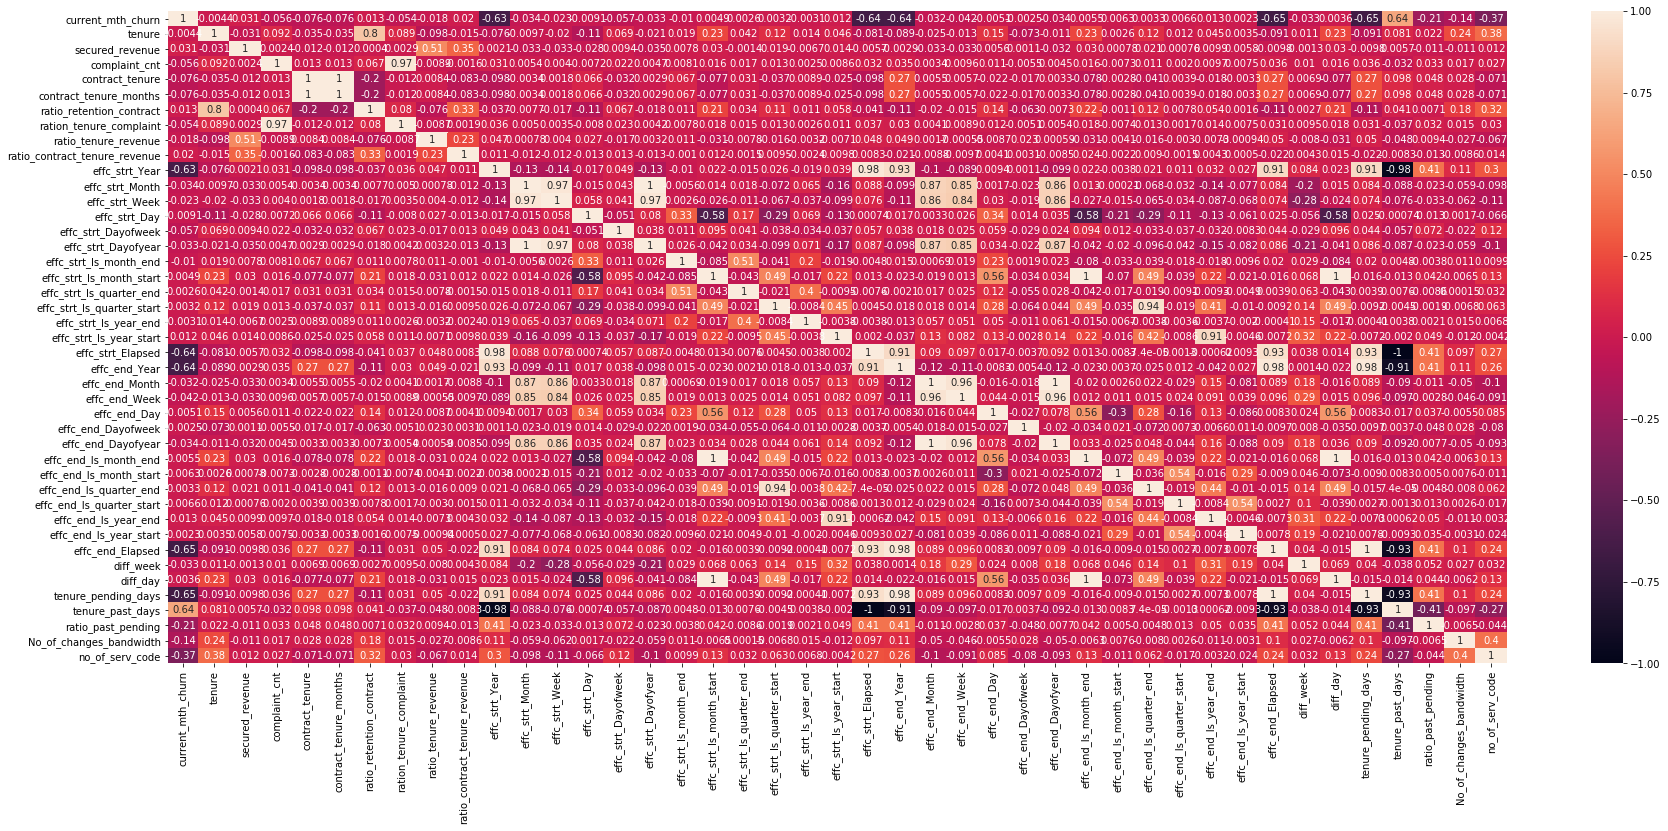

In [0]:
plt.figure(figsize=(30, 12))
sns.heatmap(df3.corr(), annot=True)
plt.show()

In [0]:
cat_feat = ['serv_code', 'bandwidth', 'with_phone_service', 'secured_revenue_bins',\
            'effc_strt_Is_month_start','effc_strt_Is_quarter_end','effc_strt_Is_quarter_start', \
            'effc_strt_Is_year_end', 'effc_strt_Is_year_start','effc_end_Is_month_end',\
       'effc_end_Is_month_start', 'effc_end_Is_quarter_end',\
       'effc_end_Is_quarter_start', 'effc_end_Is_year_end',\
       'effc_end_Is_year_start','tenure_bins']

**LGBM**

In [0]:
# Objective Function
train_data = lgb.Dataset(data=x_train, label=y_train, free_raw_data=False)
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary','num_iterations': 1500,
                  'learning_rate':0.05, 'early_stopping_round':150,
                  'metric':'auc'} # ,'boost_from_average':False}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=5, seed=11,
                           stratified=True,categorical_feature=cat_feat,
                            verbose_eval =None)
        return max(cv_result['auc-mean'])

In [0]:
pbs = {'num_leaves': (200, 300),
        'feature_fraction': (0.1, 0.9),
        'bagging_fraction': (0.8, 1),
        'max_depth': (11, 29),
        'lambda_l1': (0, 2),
        'lambda_l2': (0, 3),
        'min_split_gain': (0.001, 0.1),
        'min_child_weight': (1, 10)
      }

In [0]:
optimizer = BayesianOptimization(lgb_eval, pbs, random_state=109)
optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bandwidth', 'effc_end_Is_month_end', 'effc_end_Is_month_start', 'effc_end_Is_quarter_end', 'effc_end_Is_quarter_start', 'effc_end_Is_year_end', 'effc_end_Is_year_start', 'effc_strt_Is_month_start', 'effc_strt_Is_quarter_end', 'effc_strt_Is_quarter_start', 'effc_strt_Is_year_end', 'effc_strt_Is_year_start', 'secured_revenue_bins', 'serv_code', 'tenure_bins', 'with_phone_service']
  '

|  1        |  0.995    |  0.9223   |  0.4931   |  1.399    |  0.5837   |  24.95    |  7.371    |  0.03714  |  297.2    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  2        |  0.9951   |  0.8186   |  0.431    |  0.1221   |  0.8978   |  28.93    |  9.292    |  0.0458   |  291.9    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  3        |  0.9953   |  0.8583   |  0.5483   |  0.9183   |  0.05462  |  28.08    |  3.797    |  0.08432  |  202.2    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  4        |  0.9949   |  0.9162   |  0.5833   |  1.696    |  0.9446   |  27.99    |  7.668    |  0.09032  |  286.7    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  5        |  0.995    |  0.9802   |  0.6788   |  1.054    |  2.295    |  14.98    |  7.737    |  0.07712  |  237.9    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  6        |  0.9952   |  0.9851   |  0.2844   |  0.571    |  2.828    |  11.93    |  1.625    |  0.03577  |  200.2    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  7        |  0.9948   |  0.8756   |  0.2227   |  1.825    |  1.352    |  27.19    |  9.512    |  0.05514  |  200.1    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  8        |  0.9954   |  0.9631   |  0.592    |  0.657    |  1.355    |  11.99    |  2.091    |  0.07461  |  300.0    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  9        |  0.9951   |  0.9728   |  0.1975   |  0.1713   |  2.125    |  11.25    |  2.664    |  0.09001  |  200.5    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  10       |  0.9954   |  0.9453   |  0.4399   |  0.2141   |  1.518    |  11.63    |  1.246    |  0.008368 |  299.8    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  11       |  0.9953   |  0.8096   |  0.1798   |  0.9876   |  0.09079  |  11.25    |  1.934    |  0.07886  |  299.3    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  12       |  0.9949   |  0.9996   |  0.331    |  0.1997   |  2.74     |  11.14    |  9.274    |  0.01167  |  200.4    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  13       |  0.9953   |  0.9728   |  0.3135   |  1.206    |  0.7824   |  11.54    |  1.915    |  0.05811  |  300.0    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  14       |  0.9953   |  0.8275   |  0.593    |  1.645    |  0.8905   |  28.64    |  2.47     |  0.001615 |  299.2    |


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  15       |  0.9953   |  0.944    |  0.6399   |  0.7788   |  1.208    |  27.72    |  1.142    |  0.08557  |  200.2    |


In [0]:
optimizer.max['params']

{'bagging_fraction': 0.9453241920919144,
 'feature_fraction': 0.43994517868421446,
 'lambda_l1': 0.21412431476507177,
 'lambda_l2': 1.5179331283900466,
 'max_depth': 11.625264507292421,
 'min_child_weight': 1.245931421697727,
 'min_split_gain': 0.00836811939322505,
 'num_leaves': 299.8253132595877}

In [0]:
p =optimizer.max['params']

In [0]:
Counter(y_train)

Counter({0: 16388, 1: 3418})

In [0]:

param = {'num_leaves': int(round(p['num_leaves'])),
         'feature_fraction': p['feature_fraction'],
         'bagging_fraction': p['bagging_fraction'],
         'max_depth': int(round(p['max_depth'])),
         'lambda_l1': p['lambda_l1'],
         'lambda_l2':p['lambda_l2'],
         'min_split_gain': p['min_split_gain'],
         'min_child_weight': p['min_child_weight'],
         'learing_rate':0.01,
         'objective': 'binary',
         'boosting_type': 'gbdt',
         'verbose': 1,
         'metric': {'auc'},
         'scale_pos_weight':5
        #  'is_unbalance':'True'         
         }

In [0]:
xg_train = lgb.Dataset(x_train, label=y_train,free_raw_data = False)
xg_valid = lgb.Dataset(x_val, label=y_val,free_raw_data = False)
model = lgb.train(param, xg_train, num_boost_round=500, valid_sets=[xg_valid], categorical_feature='auto', verbose_eval=100)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	valid_0's auc: 0.995957
[200]	valid_0's auc: 0.995868
[300]	valid_0's auc: 0.995916
[400]	valid_0's auc: 0.995887
[500]	valid_0's auc: 0.995895


In [0]:
y_pred_test = model.predict(x_test)
y_pred_val = model.predict(x_val)
y_pred_train = model.predict(x_train)

In [0]:
def convert_output(y):
  req = np.where(y>0.5,1,0)
  return req

In [0]:
y_pred_test = convert_output(y_pred_test)
y_pred_val = convert_output(y_pred_val)
y_pred_train = convert_output(y_pred_train)

In [0]:
print("Training prediction")
print(classification_report(y_train, y_pred_train))
cm = confusion_matrix(y_train, y_pred_train)
cm_df = pd.DataFrame(cm.T, index=[0,1], columns=[0,1])
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('confusion_matrix')
print(cm_df)

Training prediction
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16388
           1       1.00      1.00      1.00      3418

    accuracy                           1.00     19806
   macro avg       1.00      1.00      1.00     19806
weighted avg       1.00      1.00      1.00     19806

confusion_matrix
True           0     1
Predicted             
0          16384     0
1              4  3418


In [0]:
f1_score(y_train, y_pred_train)

0.9994152046783625

In [0]:
print("validation prediction")
print('classification_report')
print(classification_report(y_val, y_pred_val))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred_val)
cm_df = pd.DataFrame(cm.T, index=[0,1], columns=[0,1])
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('confusion_matrix')
print(cm_df)

validation prediction
classification_report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5463
           1       0.92      0.96      0.94      1140

    accuracy                           0.98      6603
   macro avg       0.96      0.97      0.96      6603
weighted avg       0.98      0.98      0.98      6603

confusion_matrix
True          0     1
Predicted            
0          5373    51
1            90  1089


In [0]:
f1_score(y_val, y_pred_val)

0.9391979301423027

In [0]:
print("testing prediction")
print('classification_report')
print(classification_report(y_test, y_pred_test))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm.T, index=[0,1], columns=[0,1])
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('confusion_matrix')
print(cm_df)

testing prediction
classification_report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     21889
           1       0.58      0.21      0.31       802

    accuracy                           0.97     22691
   macro avg       0.78      0.60      0.64     22691
weighted avg       0.96      0.97      0.96     22691

confusion_matrix
True           0    1
Predicted            
0          21770  636
1            119  166


In [0]:
f1_score(y_pred_test,y_test)

0.30542778288868444

In [0]:
Counter(y_test)

Counter({0: 21889, 1: 802})

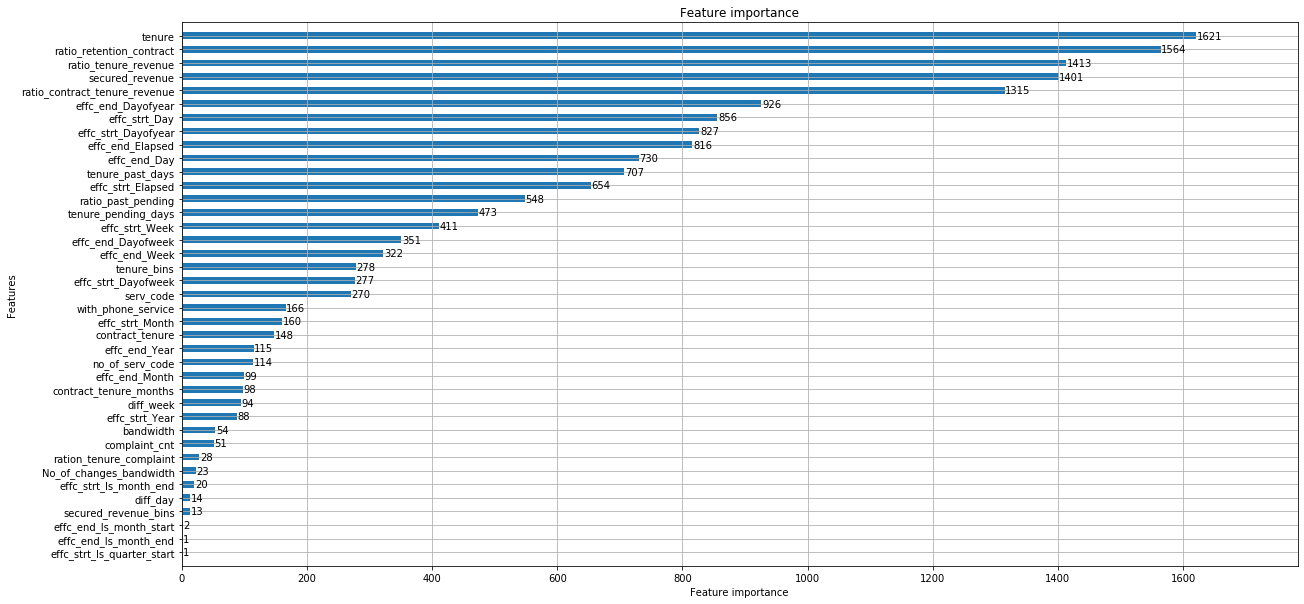

In [0]:
lgb.plot_importance(model, height=0.5,ignore_zero=True, figsize=(20,10))

CATBOOST

In [0]:
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 64.0MB 63kB/s 


In [0]:
x_train[x_train.columns[8]].dtypes

CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0], ordered=False)

In [0]:
c_train = x_train.copy()
c_val = x_val.copy()
c_test = x_test.copy()

In [0]:
c_train['serv_code'] = c_train['serv_code'].astype('str')
c_train['bandwidth'] = c_train['bandwidth'].astype('str')
c_train['with_phone_service'] = c_train['with_phone_service'].astype('str')
c_train['secured_revenue_bins'] = c_train['secured_revenue_bins'].astype('str')
c_train['tenure_bins'] = c_train['tenure_bins'].astype('int')

In [0]:
c_val['serv_code'] = c_val['serv_code'].astype('str')
c_val['bandwidth'] = c_val['bandwidth'].astype('str')
c_val['with_phone_service'] = c_val['with_phone_service'].astype('str')
c_val['secured_revenue_bins'] = c_val['secured_revenue_bins'].astype('str')
c_val['tenure_bins'] = c_val['tenure_bins'].astype('int')

In [0]:
c_test['serv_code'] = c_test['serv_code'].astype('str')
c_test['bandwidth'] = c_test['bandwidth'].astype('str')
c_test['with_phone_service'] = c_test['with_phone_service'].astype('str')
c_test['secured_revenue_bins'] = c_test['secured_revenue_bins'].astype('str')
c_test['tenure_bins'] = c_test['tenure_bins'].astype('int')

In [0]:
categorical_features_indices = x_train.columns.get_indexer(cat_feat)
m=CatBoostClassifier(n_estimators=2500,random_state=1994,eval_metric='F1',learning_rate=0.03, scale_pos_weight=5)
m.fit(c_train,y_train,eval_set=[(c_val, y_val)], early_stopping_rounds=200,verbose=200,cat_features=categorical_features_indices)

0:	learn: 0.9434749	test: 0.9401442	best: 0.9401442 (0)	total: 94.5ms	remaining: 3m 56s
200:	learn: 0.9728208	test: 0.9650687	best: 0.9650687 (198)	total: 8.5s	remaining: 1m 37s
400:	learn: 0.9803785	test: 0.9700158	best: 0.9700158 (390)	total: 16.9s	remaining: 1m 28s
600:	learn: 0.9835098	test: 0.9716812	best: 0.9716812 (598)	total: 25.4s	remaining: 1m 20s
800:	learn: 0.9853089	test: 0.9724269	best: 0.9725292 (768)	total: 33.9s	remaining: 1m 11s
1000:	learn: 0.9869769	test: 0.9736842	best: 0.9736842 (998)	total: 42.3s	remaining: 1m 3s
1200:	learn: 0.9879116	test: 0.9741969	best: 0.9744022 (1171)	total: 50.7s	remaining: 54.8s
1400:	learn: 0.9893698	test: 0.9746075	best: 0.9746075 (1399)	total: 59.2s	remaining: 46.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9746075229
bestIteration = 1399

Shrink model to first 1400 iterations.


In [0]:
feature_score = pd.DataFrame(list(zip(c_train.dtypes.index, m.get_feature_importance(Pool(c_train, label=y_train, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

NameError: ignored

In [0]:
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

In [0]:
c_pred_val = m.predict(c_val)

In [0]:
c_pred_test = m.predict(c_test)

In [0]:
print(f1_score(c_pred_val, y_val))

0.9386098427194318


In [0]:
print("testing prediction")
print('classification_report')
print(classification_report(y_test, c_pred_test))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, c_pred_test)
cm_df = pd.DataFrame(cm.T, index=[0,1], columns=[0,1])
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('confusion_matrix')
print(cm_df)

testing prediction
classification_report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     21831
           1       0.33      0.24      0.27       774

    accuracy                           0.96     22605
   macro avg       0.65      0.61      0.63     22605
weighted avg       0.95      0.96      0.95     22605

confusion_matrix
True           0    1
Predicted            
0          21456  591
1            375  183


In [0]:
roc_auc_score(c_pred_test, y_test)

In [0]:
feature_score.head()

In [0]:
feature_score.sort_values(by=['Score'], inplace=True, ascending=False)

In [0]:
import matplotlib.pyplot as plt
feature_score.head(10).plot.barh(x='Feature')

In [0]:
feature_score.head(10).plot(kind='barh')

**Random forest classifier**

In [0]:
x_train.head()

,serv_code,bandwidth,with_phone_service,tenure,secured_revenue,complaint_cnt,contract_tenure,secured_revenue_bins,tenure_bins,contract_tenure_months,ratio_retention_contract,ration_tenure_complaint,ratio_tenure_revenue,ratio_contract_tenure_revenue,effc_strt_Year,effc_strt_Month,effc_strt_Week,effc_strt_Day,effc_strt_Dayofweek,effc_strt_Dayofyear,effc_strt_Is_month_end,effc_strt_Is_month_start,effc_strt_Is_quarter_end,effc_strt_Is_quarter_start,effc_strt_Is_year_end,effc_strt_Is_year_start,effc_strt_Elapsed,effc_end_Year,effc_end_Month,effc_end_Week,effc_end_Day,effc_end_Dayofweek,effc_end_Dayofyear,effc_end_Is_month_end,effc_end_Is_month_start,effc_end_Is_quarter_end,effc_end_Is_quarter_start,effc_end_Is_year_end,effc_end_Is_year_start,effc_end_Elapsed,diff_week,diff_day,tenure_pending_days,tenure_past_days,ratio_past_pending,No_of_changes_bandwidth,no_of_serv_code
14083,VS100FSR,100M,Y,62,0.029674,0,0.198794,4,2.0,60.833333,1.019178,0.0,0.000887,0.002171,2018,8,33,16,3,228,0,0,0,0,0,0,0.904204,2020,8,33,15,5,228,0,0,0,0,0,0,0.625212,0,-1,179,551,0.324864,2,2
21342,VS100FSN,100M,N,24,0.011442,0,0.298876,2,0.0,91.250000,0.263014,0.0,0.000538,0.000806,2017,9,39,29,4,272,0,0,0,0,0,0,0.847259,2020,9,40,28,0,272,0,0,0,0,0,0,0.630191,1,-1,223,872,0.255734,1,1
10066,VPXMXMDUXX,10M,Y,94,0.008647,0,0.198794,1,3.0,60.833333,1.545205,0.0,0.000127,0.000733,2011,12,50,13,1,347,0,0,0,0,0,0,0.471705,2013,12,50,12,3,346,0,0,0,0,0,0,0.349327,0,-1,-2259,2989,-0.755771,1,1
25966,VS100DUN,100M,N,3,0.007721,0,0.198794,1,0.0,60.833333,0.049315,0.0,0.001124,0.000670,2019,6,26,25,1,176,0,0,0,0,0,0,0.959730,2021,6,25,24,3,175,0,0,0,0,0,0,0.660631,-1,-1,492,238,2.067227,1,1
18813,VS100FSR,100M,N,36,0.052565,0,0.198794,4,1.0,60.833333,0.591781,0.0,0.002847,0.003737,2018,10,41,10,2,283,0,0,0,0,0,0,0.913961,2020,10,41,9,4,283,0,0,0,0,0,0,0.631436,0,-1,234,496,0.471774,1,2


In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(rdf['serv_code'])
x_train['serv_code'] = le.transform(x_train['serv_code'])
x_val['serv_code'] = le.transform(x_val['serv_code'])
x_test['serv_code'] = le.transform(x_test['serv_code'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
le.fit(rdf['bandwidth'])
x_train['bandwidth'] = le.transform(x_train['bandwidth'])
x_val['bandwidth'] = le.transform(x_val['bandwidth'])
x_test['bandwidth'] = le.transform(x_test['bandwidth'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
le.fit(rdf['with_phone_service'])
x_train['with_phone_service'] = le.transform(x_train['with_phone_service'])
x_val['with_phone_service'] = le.transform(x_val['with_phone_service'])
x_test['with_phone_service'] = le.transform(x_test['with_phone_service'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
x_train['serv_code'].head()

14083    285
21342    284
10066    233
25966    265
18813    285
Name: serv_code, dtype: int64

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
criterion = ['gini','entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion':criterion}


In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,\
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [0]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [0]:
rf1 = RandomForestClassifier(bootstrap='True',max_depth=100,\
                            max_features= 3, min_samples_leaf= 3,\
                             min_samples_split= 8,n_estimators= 200,\
                             )

In [0]:
rf1.fit(x_train, y_train)

RandomForestClassifier(bootstrap='True', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# grid_search.best_params_

# 'bootstrap': True,
#  'max_depth': 100,
#  'max_features': 3,
#  'min_samples_leaf': 3,
#  'min_samples_split': 8,
#  'n_estimators': 200

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [0]:
x_test[features_to_scale].replace({np.inf:0}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [0]:
pred_train = rf1.predict_proba(x_test.fillna(0))

In [0]:
pred_train = np.where(pred_train>0.5,1,0)

In [0]:
pred_train = np.argmax(pred_train, axis=1)

In [0]:
f1_score(pred_train, y_test)

0.3556658395368073

In [0]:
cm = confusion_matrix(y_test, pred_train)
cm_df = pd.DataFrame(cm.T, index=[0,1], columns=[0,1])
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('confusion_matrix')
print(cm_df)

confusion_matrix
True           0    1
Predicted            
0          21697  587
1            192  215


In [0]:
df_test3.replace({np.inf:0}, inplace=True)
df_test3.to_csv('/content/drive/My Drive/Churn_prediction/aug3.csv', index=False)

In [0]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(x_train,y_train), range(5)):
    rf1.fit(x_train.iloc[train], y_train.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

NameError: ignored